In [ ]:
! nvidia-smi

Sat Oct 29 18:18:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


torch.manual_seed(123)

In [ ]:
! pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 15.5 MB/s 
     |████████████████████████████████| 212 kB 76.5 MB/s 
     |████████████████████████████████| 115 kB 61.6 MB/s 
     |████████████████████████████████| 163 kB 73.4 MB/s 
     |████████████████████████████████| 127 kB 70.0 MB/s 
     |████████████████████████████████| 115 kB 68.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
!pip install gensim==4.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.4 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
!python -m spacy download en_core_web_sm
!python -m spacy download ja_core_news_sm
!python -m spacy download fi_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 12.1 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.0 MB 14.3 MB/s 
     |████████████████████████████████| 2.2 MB 13.9 MB/s 
  Created wheel for sudachidict-core: filename=SudachiDict_core-20221021-py3-none-any.whl size=71574782 sha256=7f3b79aba54410e9015342204fe61abeded659a6db7967dab8f6ee798c9a4c8c
  Stored in directory: /root/.cache/pip/wheels/66/a9/e1/bde612c31f0ae6877e7e39f278076befd399c488cba80292b6
Successfully built sudachidict-core
✔ Download and installation successful
You can now load the package via spacy.load('ja_core_news_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     

In [ ]:
! pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 4.6 MB/s 
     |████████████████████████████████| 5.3 MB 58.9 MB/s 
     |████████████████████████████████| 1.3 MB 51.3 MB/s 
     |████████████████████████████████| 7.6 MB 56.9 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=b58b92678d02e1bcb005967679ad9071a1e7a5a7c1b6cd5b4687fbfad1fe5fcf
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [ ]:
import gensim
import torchtext
import spacy
import numpy
import pandas
# import nni
import torch.utils.data as Data
from tqdm.autonotebook import tqdm
from datasets import load_dataset
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
from matplotlib import pyplot as plt
from collections import OrderedDict
from sentence_transformers import SentenceTransformer

In [ ]:
# epochs
epochs = 100
# batch size
batch_size = 128
# learning rate
lr = 0.0001


# model parameters
input_dim = 384
hidden_dim = 256
output_dim = 2

In [ ]:
tokenizer_en = spacy.load("en_core_web_sm")
tokenizer_ja = spacy.load("ja_core_news_sm")
tokenizer_fi = spacy.load("fi_core_news_sm")


In [ ]:
dataset = load_dataset("copenlu/answerable_tydiqa")
train_set = dataset["train"]
validation_set = dataset["validation"]

dataset

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/copenlu___parquet/copenlu--nlp_course_tydiqa-9ffd3d37cf2899c6/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['question_text', 'document_title', 'language', 'annotations', 'document_plaintext', 'document_url'],
        num_rows: 116067
    })
    validation: Dataset({
        features: ['question_text', 'document_title', 'language', 'annotations', 'document_plaintext', 'document_url'],
        num_rows: 13325
    })
})

In [ ]:
def getLanguageDataSet(data, language):
    return data.filter(lambda x: x['language'] == language)



def getJapaneseDataSet(data):
    return getLanguageDataSet(data, "japanese")

def getEnglishDataSet(data):
    return getLanguageDataSet(data, "english")

def getFinnishDataSet(data):
    return getLanguageDataSet(data, "finnish")



def build_vocab(dataSet, tokenizer):
    counter = Counter()
    for data in dataSet:
        counter.update([token.text for token in tokenizer(data['document_plaintext'])])
        # counter.update(tokenizer(data['document_plaintext']))
    return Vocab(counter)


In [ ]:
en_train_set = getEnglishDataSet(train_set)
en_validation_set = getEnglishDataSet(validation_set)

ja_train_set = getJapaneseDataSet(train_set)
ja_validation_set = getJapaneseDataSet(validation_set)

fi_train_set = getFinnishDataSet(train_set)
fi_validation_set = getFinnishDataSet(validation_set)

print(numpy.shape(en_train_set))
print(en_train_set[0])

  0%|          | 0/117 [00:00<?, ?ba/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/117 [00:00<?, ?ba/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/117 [00:00<?, ?ba/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

(7389, 6)
{'question_text': 'When was quantum field theory developed?', 'document_title': 'Quantum field theory', 'language': 'english', 'annotations': {'answer_start': [159], 'answer_text': ['1920s']}, 'document_plaintext': 'Quantum field theory naturally began with the study of electromagnetic interactions, as the electromagnetic field was the only known classical field as of the 1920s.[8]:1', 'document_url': 'https://en.wikipedia.org/wiki/Quantum%20field%20theory'}


In [ ]:
def getWord2VecModel(train_dataSet, test_dataSet, tokenizer):
    sentences = []
    keys = ["document_plaintext", "question_text"]
    for element in train_dataSet:
        for key in keys:
            sentences.append([token.text for token in tokenizer(element[key])])
            # sentences.append(tokenizer(element[key]))
    for element in test_dataSet:
        for key in keys:
            sentences.append([token.text for token in tokenizer(element[key])])
            # sentences.append(tokenizer(element[key]))

    print(numpy.shape(sentences))
    
    w2v_model = gensim.models.Word2Vec(sentences, vector_size=128, min_count=1, window=10, epochs=5)

    # w2v_model.wv.save_word2vec_format("vector.txt", binary=False)

    return w2v_model

In [ ]:
# def data_process(dataSet, w2vModel, tokenizer, tokenPart="document"):
#     data = []
#     for element in dataSet:
#         if tokenPart == "document":
#             en_tensor_ = torch.tensor([w2vModel.wv.get_vector(token) for token in [token_.text for token_ in tokenizer(element["document_plaintext"])]], dtype=torch.float32)
#             # en_tensor_ = torch.tensor([w2vModel.get_vector(token) for token in tokenizer(element["document_plaintext"])], dtype=torch.float32)
#             en_tensor_ = torch.mean(en_tensor_, dim=0, keepdim=True).cuda()
#             data.append(en_tensor_)
#         elif tokenPart == "question":
#             en_tensor_ = torch.tensor([w2vModel.wv.get_vector(token) for token in [token_.text for token_ in tokenizer(element["question_text"])]], dtype=torch.float32)
#             # en_tensor_ = torch.tensor([w2vModel.get_vector(token) for token in tokenizer(element["question_text"])], dtype=torch.float32)
#             en_tensor_ = torch.mean(en_tensor_, dim=0, keepdim=True).cuda()
#             data.append(en_tensor_)
#         elif tokenPart == "answer":
#             if (element["annotations"]["answer_start"] == [-1]):
#                 # en_tensor_ = torch.tensor([w2vModel.get_vector(token) for token in tokenizer(element["annotations"]["answer_text"])], dtype=torch.float32)
#                 # data.append(en_tensor_)
#                 data.append(torch.tensor([0], dtype=torch.int64).cuda())
#             else:
#                 data.append(torch.tensor([1], dtype=torch.int64).cuda())
#     return torch.cat(data, dim=0)

def data_process(dataSet, SbertModel, tokenizer, tokenPart="document"):
    data = []
    for element in dataSet:
        if tokenPart == "document":
            en_tensor_ = torch.tensor([SbertModel.encode(element["document_plaintext"])], dtype=torch.float32).cuda()
            data.append(en_tensor_)
        elif tokenPart == "question":
            en_tensor_ = torch.tensor([SbertModel.encode((element["question_text"]))], dtype=torch.float32).cuda()
            data.append(en_tensor_)
        elif tokenPart == "answer":
            if (element["annotations"]["answer_start"] == [-1]):
                # en_tensor_ = torch.tensor([w2vModel.get_vector(token) for token in tokenizer(element["annotations"]["answer_text"])], dtype=torch.float32)
                # data.append(en_tensor_)
                data.append(torch.tensor([0], dtype=torch.int64).cuda())
            else:
                data.append(torch.tensor([1], dtype=torch.int64).cuda())
    return torch.cat(data, dim=0)


In [ ]:
def getEnglishData(data):
    tokenizer = tokenizer_en
    # tokenizer = get_tokenizer('basic_english', language="en")
    print("tokenizer finished")
    englishDataSet = getEnglishDataSet(data)
    print("englishDataSet finished")
    # englishVocab = build_vocab(englishDataSet, tokenizer)
    print("englishVocab finished")
    # model = getWord2VecModel(en_train_set, en_validation_set, tokenizer)
    model = SentenceTransformer('all-MiniLM-L6-v2')
    print("w2vModel finished")
    answer_set = data_process(englishDataSet, model, tokenizer, "answer")
    print("answer_set finished")
    question_set = data_process(englishDataSet, model, tokenizer, "question")
    print("question_set finished")
    document_set = data_process(englishDataSet, model, tokenizer, "document")
    print("document_set finished")

    return answer_set, question_set, document_set


# todo Japanese的tokenizer
def getJapaneseData(data):
    tokenizer = tokenizer_ja
    # tokenizer = get_tokenizer('basic_english', language="en")
    print("tokenizer finished")
    japaneseDataSet = getJapaneseDataSet(data)
    print("japaneseDataSet finished")
    # japansesVocab = build_vocab(japaneseDataSet, tokenizer)
    print("japansesVocab finished")
    # model = getWord2VecModel(ja_train_set, ja_validation_set, tokenizer)
    model = SentenceTransformer('all-MiniLM-L6-v2')
    print("w2vModel finished")
    answer_set = data_process(japaneseDataSet, model, tokenizer, "answer")
    print("answer_set finished")
    question_set = data_process(japaneseDataSet, model, tokenizer, "question")
    print("question_set finished")
    document_set = data_process(japaneseDataSet, model, tokenizer, "document")
    print("document_set finished")

    return answer_set, question_set, document_set

# todo Finnish的tokenizer
def getFinnishData(data):
    tokenizer = tokenizer_fi
    # tokenizer = get_tokenizer('basic_english', language="en")
    print("tokenizer finished")
    finnishDataSet = getFinnishDataSet(data)
    print("finnishDataSet finished")
    # finnishVocab = build_vocab(finnishDataSet, tokenizer)
    print("finnishVocab finished")
    # model = getWord2VecModel(fi_train_set, fi_validation_set, tokenizer)
    model = SentenceTransformer('all-MiniLM-L6-v2')
    print("w2vModel finished")
    answer_set = data_process(finnishDataSet, model, tokenizer, "answer")
    print("answer_set finished")
    question_set = data_process(finnishDataSet, model, tokenizer, "question")
    print("question_set finished")
    document_set = data_process(finnishDataSet, model, tokenizer, "document")
    print("document_set finished")

    return answer_set, question_set, document_set


In [ ]:
# train_set_en
english_answer_train_set, english_question_train_set, english_document_train_set = getEnglishData(en_train_set)
# val_set_en
english_answer_validation_set, english_question_validation_set, english_document_validation_set = getEnglishData(en_validation_set)

# train_set_ja
japanese_answer_train_set, japanese_question_train_set, japanese_document_train_set = getJapaneseData(ja_train_set)
# val_set_ja
japanese_answer_validation_set, japanese_question_validation_set, japanese_document_validation_set = getJapaneseData(ja_validation_set)

# train_set_fi
finnish_answer_train_set, finnish_question_train_set, finnish_document_train_set = getFinnishData(fi_train_set)
# val_set_fi
finnish_answer_validation_set, finnish_question_validation_set, finnish_document_validation_set = getFinnishData(fi_validation_set)


tokenizer finished


  0%|          | 0/8 [00:00<?, ?ba/s]

englishDataSet finished
englishVocab finished


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

w2vModel finished
answer_set finished


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


question_set finished
document_set finished
tokenizer finished


  0%|          | 0/1 [00:00<?, ?ba/s]

englishDataSet finished
englishVocab finished
w2vModel finished
answer_set finished
question_set finished
document_set finished
tokenizer finished


  0%|          | 0/9 [00:00<?, ?ba/s]

japaneseDataSet finished
japansesVocab finished
w2vModel finished
answer_set finished
question_set finished
document_set finished
tokenizer finished


  0%|          | 0/2 [00:00<?, ?ba/s]

japaneseDataSet finished
japansesVocab finished
w2vModel finished
answer_set finished
question_set finished
document_set finished
tokenizer finished


  0%|          | 0/14 [00:00<?, ?ba/s]

finnishDataSet finished
finnishVocab finished
w2vModel finished
answer_set finished
question_set finished
document_set finished
tokenizer finished


  0%|          | 0/2 [00:00<?, ?ba/s]

finnishDataSet finished
finnishVocab finished
w2vModel finished
answer_set finished
question_set finished
document_set finished


In [ ]:
# multilingual_set
multilingual_answer_train_set = torch.cat((torch.cat((english_answer_train_set, japanese_answer_train_set), 0), finnish_answer_train_set), 0)
multilingual_question_train_set = torch.cat((torch.cat((english_question_train_set, japanese_question_train_set), 0), finnish_question_train_set), 0)
multilingual_document_train_set = torch.cat((torch.cat((english_document_train_set, japanese_document_train_set), 0), finnish_document_train_set), 0)

multilingual_answer_validation_set = torch.cat((torch.cat((english_answer_validation_set, japanese_answer_validation_set), 0), finnish_answer_validation_set), 0)
multilingual_question_validation_set = torch.cat((torch.cat((english_question_validation_set, japanese_question_validation_set), 0), finnish_question_validation_set), 0)
multilingual_document_validation_set = torch.cat((torch.cat((english_document_validation_set, japanese_document_validation_set), 0), finnish_document_validation_set), 0)

In [ ]:
# dataloader_en
torch_dataset_en = Data.TensorDataset(english_question_train_set, english_document_train_set, english_answer_train_set)
train_loader_en = Data.DataLoader(dataset=torch_dataset_en, batch_size=batch_size, shuffle=True)

# for question_vec, document_vec, label in train_loader_en:
#   print(numpy.shape(question_vec))
#   print(question_vec[0])
#   print(numpy.shape(document_vec))
#   print(document_vec[0])
#   print(numpy.shape(label))
#   print(label)
#   print(numpy.shape(question_vec + document_vec))
#   break

# print("----------------------------------------------------")

# dataloader_ja
torch_dataset_ja = Data.TensorDataset(japanese_question_train_set, japanese_document_train_set, japanese_answer_train_set)
train_loader_ja = Data.DataLoader(dataset=torch_dataset_ja, batch_size=batch_size, shuffle=True)

# dataloader_fi
torch_dataset_fi = Data.TensorDataset(finnish_question_train_set, finnish_document_train_set, finnish_answer_train_set)
train_loader_fi = Data.DataLoader(dataset=torch_dataset_fi, batch_size=batch_size, shuffle=True)


In [ ]:
# dataloader_multi
torch_dataset_multi = Data.TensorDataset(multilingual_question_train_set, multilingual_document_train_set, multilingual_answer_train_set)
train_loader_multi = Data.DataLoader(dataset=torch_dataset_multi, batch_size=batch_size, shuffle=True)

# for question_vec, document_vec, label in train_loader_multi:
#   print(numpy.shape(question_vec))
#   print(question_vec[0])
#   print(numpy.shape(document_vec))
#   print(document_vec[0])
#   print(numpy.shape(label))
#   print(label)
#   print(numpy.shape(question_vec + document_vec))
#   break

In [ ]:
class attention(nn.Module):
    def __init__(self, hidden_dim, attn_drop):
        super(attention, self).__init__()
        self.fc = nn.Linear(hidden_dim, hidden_dim, bias=True)
        nn.init.xavier_normal_(self.fc.weight, gain=1.414)

        self.tanh = nn.Tanh()
        self.att = nn.Parameter(torch.empty(size=(1, hidden_dim)), requires_grad=True)
        nn.init.xavier_normal_(self.att.data, gain=1.414)

        self.softmax = nn.Softmax()
        if attn_drop:
            self.attn_drop = nn.Dropout(attn_drop)
        else:
            self.attn_drop = lambda x: x

    def forward(self, embeds):
        beta = []
        attn_curr = self.attn_drop(self.att)
        for embed in embeds:
            sp = self.tanh(self.fc(embed)).mean(dim=0)
            beta.append(attn_curr.matmul(sp.t()))
        beta = torch.cat(beta, dim=-1).view(-1)
        beta = self.softmax(beta)
        #print(ntype+" mp ", beta.data.cpu().numpy())  # semantic attention
        z_mp = 0
        for i in range(len(embeds)):
            z_mp = z_mp+ embeds[i]*beta[i]
        return z_mp


In [ ]:
class QA_model(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim):
        super(QA_model, self).__init__()
        self.que_in_mlp = nn.Linear(input_dim,hidden_dim)
        self.context_in_mlp = nn.Linear(input_dim,hidden_dim)
        self.output_layer = nn.Linear(hidden_dim,output_dim)
        self.attention_layer = attention(hidden_dim,0.5)

    def forward(self,question,context):
        q_vec = F.leaky_relu(self.que_in_mlp(question))
        c_vec = F.leaky_relu(self.context_in_mlp(context))
        attention_out = self.attention_layer([q_vec,c_vec])
        predict_label = self.output_layer(attention_out)

        return predict_label

class QA_LR_model(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim):
        super(QA_LR_model, self).__init__()
        self.input_layer = nn.Linear(input_dim*2,hidden_dim)
        self.relu_0 = nn.ReLU()
        self.hidden_layer_0 = nn.Linear(hidden_dim,hidden_dim*2)
        self.relu_1 = nn.ReLU()
        self.hidden_layer_1 = nn.Linear(hidden_dim*2,hidden_dim)
        self.relu_2 = nn.ReLU()
        self.output_layer = nn.Linear(hidden_dim,output_dim)

    def forward(self,data):
        input = self.input_layer(data)
        relu_0 = self.relu_0(input)
        hidden_0 = self.hidden_layer_0(relu_0)
        relu_1 = self.relu_1(hidden_0)
        hidden_1 = self.hidden_layer_1(relu_1)
        relu_2 = self.relu_2(hidden_1)
        output = F.sigmoid(self.output_layer(relu_2))

        return output


In [ ]:
# attention model define
model_en = QA_model(input_dim, hidden_dim, output_dim).to('cuda')
model_ja = QA_model(input_dim, hidden_dim, output_dim).to('cuda')
model_fi = QA_model(input_dim, hidden_dim, output_dim).to('cuda')

# LR model define
lr_model_en = QA_LR_model(input_dim, hidden_dim, output_dim).to('cuda')
lr_model_ja = QA_LR_model(input_dim, hidden_dim, output_dim).to('cuda')
lr_model_fi = QA_LR_model(input_dim, hidden_dim, output_dim).to('cuda')

# show model structure
print(model_en)
print(lr_model_en)


QA_model(
  (que_in_mlp): Linear(in_features=384, out_features=256, bias=True)
  (context_in_mlp): Linear(in_features=384, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=2, bias=True)
  (attention_layer): attention(
    (fc): Linear(in_features=256, out_features=256, bias=True)
    (tanh): Tanh()
    (softmax): Softmax(dim=None)
    (attn_drop): Dropout(p=0.5, inplace=False)
  )
)
QA_LR_model(
  (input_layer): Linear(in_features=768, out_features=256, bias=True)
  (relu_0): ReLU()
  (hidden_layer_0): Linear(in_features=256, out_features=512, bias=True)
  (relu_1): ReLU()
  (hidden_layer_1): Linear(in_features=512, out_features=256, bias=True)
  (relu_2): ReLU()
  (output_layer): Linear(in_features=256, out_features=2, bias=True)
)


In [ ]:
# model defin
lr_model_multi = QA_LR_model(input_dim, hidden_dim, output_dim).to('cuda')

print(lr_model_multi)

QA_LR_model(
  (input_layer): Linear(in_features=768, out_features=256, bias=True)
  (relu_0): ReLU()
  (hidden_layer_0): Linear(in_features=256, out_features=512, bias=True)
  (relu_1): ReLU()
  (hidden_layer_1): Linear(in_features=512, out_features=256, bias=True)
  (relu_2): ReLU()
  (output_layer): Linear(in_features=256, out_features=2, bias=True)
)


In [ ]:
# loss function
criterion = nn.CrossEntropyLoss()

criterion_lr = nn.MSELoss()

# optimizer
optimizer_en = torch.optim.Adam(model_en.parameters(), lr=lr, amsgrad=True)
optimizer_ja = torch.optim.Adam(model_ja.parameters(), lr=lr, amsgrad=True)
optimizer_fi = torch.optim.Adam(model_fi.parameters(), lr=lr, amsgrad=True)

optimizer_en_lr = torch.optim.Adam(lr_model_en.parameters(), lr=lr, amsgrad=True)
optimizer_ja_lr = torch.optim.Adam(lr_model_ja.parameters(), lr=lr, amsgrad=True)
optimizer_fi_lr = torch.optim.Adam(lr_model_fi.parameters(), lr=lr, amsgrad=True)

In [ ]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer_multi_lr = torch.optim.Adam(lr_model_multi.parameters(), lr=lr, amsgrad=True)

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch: 0 loss: 0.6285 acc: 0.6590909090909091
epoch: 5 loss: 0.5607 acc: 0.75
epoch: 10 loss: 0.4627 acc: 0.8409090909090909
epoch: 15 loss: 0.4407 acc: 0.8863636363636364
epoch: 20 loss: 0.4066 acc: 0.9090909090909091
epoch: 25 loss: 0.3905 acc: 0.9318181818181818
epoch: 30 loss: 0.382 acc: 0.9318181818181818
epoch: 35 loss: 0.4059 acc: 0.9090909090909091
epoch: 40 loss: 0.4514 acc: 0.8636363636363636
epoch: 45 loss: 0.3589 acc: 0.9545454545454546
epoch: 50 loss: 0.3594 acc: 0.9545454545454546
epoch: 55 loss: 0.3823 acc: 0.9318181818181818
epoch: 60 loss: 0.3364 acc: 0.9772727272727273
epoch: 65 loss: 0.3589 acc: 0.9545454545454546
epoch: 70 loss: 0.3588 acc: 0.9545454545454546
epoch: 75 loss: 0.3818 acc: 0.9318181818181818
epoch: 80 loss: 0.3817 acc: 0.9318181818181818
epoch: 85 loss: 0.427 acc: 0.8863636363636364
epoch: 90 loss: 0.427 acc: 0.8863636363636364
epoch: 95 loss: 0.3816 acc: 0.9318181818181818
max acc multi: 1.0


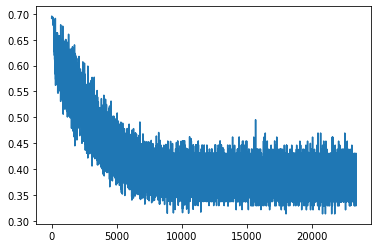

In [ ]:
# lr model
max_acc_multi = 0
loss_list = []
for epoch in tqdm(range(epochs)):
    lr_model_multi.train()
    batch_num = 0
    for question_vec, document_vec, label in train_loader_multi:
        data = torch.cat((question_vec, document_vec), 1)
        # print(numpy.shape(data))
        predict_label = lr_model_multi(data)
        loss = criterion(predict_label, label)

        pred = predict_label.max(-1, keepdim=True)[1]
        acc = pred.eq(label.view_as(pred)).sum().item() / predict_label.shape[0]
        optimizer_multi_lr.zero_grad()
        if (acc > max_acc_multi):
            max_acc_multi = acc
            torch.save(lr_model_multi.state_dict(), 'lr_model_multi.pth')
        loss.backward()
        optimizer_multi_lr.step()
        batch_num += 1
        loss_list.append(round(loss.item(), 4))
    if epoch % 5 == 0:
        print("epoch:", epoch, "loss:", round(loss.item(), 4), "acc:", acc)
print("max acc multi:", max_acc_multi)

plt.cla()
plt.plot(loss_list)

  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 0 loss: 0.6707 acc: 0.6344086021505376
epoch: 5 loss: 0.5675 acc: 0.7204301075268817
epoch: 10 loss: 0.5664 acc: 0.6774193548387096
epoch: 15 loss: 0.5525 acc: 0.7419354838709677
epoch: 20 loss: 0.4609 acc: 0.7741935483870968
epoch: 25 loss: 0.4896 acc: 0.7311827956989247
epoch: 30 loss: 0.4752 acc: 0.7526881720430108
epoch: 35 loss: 0.466 acc: 0.7741935483870968
epoch: 40 loss: 0.5133 acc: 0.7849462365591398
epoch: 45 loss: 0.4199 acc: 0.7741935483870968
epoch: 50 loss: 0.4522 acc: 0.7956989247311828
epoch: 55 loss: 0.4369 acc: 0.7956989247311828
epoch: 60 loss: 0.4812 acc: 0.7634408602150538
epoch: 65 loss: 0.3999 acc: 0.7526881720430108
epoch: 70 loss: 0.378 acc: 0.8172043010752689
epoch: 75 loss: 0.3591 acc: 0.8279569892473119
epoch: 80 loss: 0.4598 acc: 0.7849462365591398
epoch: 85 loss: 0.3909 acc: 0.8494623655913979
epoch: 90 loss: 0.2802 acc: 0.8602150537634409
epoch: 95 loss: 0.2706 acc: 0.8924731182795699
epoch: 100 loss: 0.3122 acc: 0.8172043010752689
epoch: 105 loss:

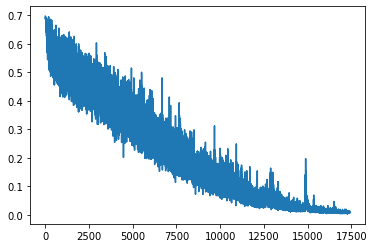

In [ ]:
# # model train en
# max_acc_en = 0
# loss_list = []
# for epoch in tqdm(range(epochs)):
#     model_en.train()
#     batch_num = 0
#     for question_vec, document_vec, label in train_loader_en:
#         predict_label = model_en(question_vec, document_vec)
#         loss = criterion(predict_label, label)
#         # print("predict_label", predict_label, "label", numpy.shape(label))
#         # break

#         pred = predict_label.max(-1, keepdim=True)[1]
#         acc = pred.eq(label.view_as(pred)).sum().item() / predict_label.shape[0]
#         optimizer_en.zero_grad()
#         if (acc > max_acc_en):
#             max_acc_en = acc
#             torch.save(model_en.state_dict(), 'model_en.pth')
#         loss.backward()
#         optimizer_en.step()
#         batch_num += 1
#         loss_list.append(round(loss.item(), 4))
#     if epoch % 5 == 0:
#         print("epoch:", epoch, "batch_num:", batch_num, "loss:", round(loss.item(), 4), "acc:", acc)
# print("max_acc_en:", max_acc_en)

# lr model
max_acc_en = 0
loss_list = []
for epoch in tqdm(range(epochs)):
    lr_model_en.train()
    batch_num = 0
    for question_vec, document_vec, label in train_loader_en:
        data = torch.cat((question_vec, document_vec), 1)
        # print(numpy.shape(data))
        predict_label = lr_model_en(data)
        loss = criterion(predict_label, label)

        pred = predict_label.max(-1, keepdim=True)[1]
        acc = pred.eq(label.view_as(pred)).sum().item() / predict_label.shape[0]
        optimizer_en_lr.zero_grad()
        if (acc > max_acc_en):
            max_acc_en = acc
            torch.save(lr_model_en.state_dict(), 'lr_model_en.pth')
        loss.backward()
        optimizer_en_lr.step()
        batch_num += 1
        loss_list.append(round(loss.item(), 4))
    if epoch % 5 == 0:
        print("epoch:", epoch, "loss:", round(loss.item(), 4), "acc:", acc)
print("max_acc_en:", max_acc_en)

plt.cla()
plt.plot(loss_list)

  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 0 batch_num: 69 loss: 0.6383 acc: 0.6756756756756757
epoch: 5 batch_num: 69 loss: 0.5944 acc: 0.6351351351351351
epoch: 10 batch_num: 69 loss: 0.419 acc: 0.8243243243243243
epoch: 15 batch_num: 69 loss: 0.3807 acc: 0.8243243243243243
epoch: 20 batch_num: 69 loss: 0.3636 acc: 0.8378378378378378
epoch: 25 batch_num: 69 loss: 0.3594 acc: 0.8243243243243243
epoch: 30 batch_num: 69 loss: 0.3228 acc: 0.8648648648648649
epoch: 35 batch_num: 69 loss: 0.3043 acc: 0.8918918918918919
epoch: 40 batch_num: 69 loss: 0.3126 acc: 0.8783783783783784
epoch: 45 batch_num: 69 loss: 0.2232 acc: 0.9054054054054054
epoch: 50 batch_num: 69 loss: 0.2455 acc: 0.8918918918918919
epoch: 55 batch_num: 69 loss: 0.3314 acc: 0.8513513513513513
epoch: 60 batch_num: 69 loss: 0.199 acc: 0.9459459459459459
epoch: 65 batch_num: 69 loss: 0.1612 acc: 0.918918918918919
epoch: 70 batch_num: 69 loss: 0.1771 acc: 0.9459459459459459
epoch: 75 batch_num: 69 loss: 0.1739 acc: 0.918918918918919
epoch: 80 batch_num: 69 loss: 

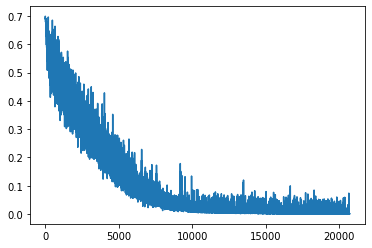

In [ ]:
# model train ja
# max_acc_ja = 0
# loss_list = []
# for epoch in tqdm(range(epochs)):
#     model_ja.train()
#     batch_num = 0
#     for question_vec, document_vec, label in train_loader_ja:
#         predict_label = model_ja(question_vec, document_vec)
#         loss = criterion(predict_label, label)

#         pred = predict_label.max(-1, keepdim=True)[1]
#         acc = pred.eq(label.view_as(pred)).sum().item() / predict_label.shape[0]
#         optimizer_ja.zero_grad()
#         if (acc > max_acc_ja):
#             max_acc_ja = acc
#             torch.save(model_ja.state_dict(), 'model_ja.pth')
#         loss.backward()
#         optimizer_ja.step()
#         batch_num += 1
#         loss_list.append(round(loss.item(), 4))
#     if epoch % 5 == 0:
#         print("epoch:", epoch, "batch_num:", batch_num, "loss:", round(loss.item(), 4), "acc:", acc)
# print("max_acc_ja:", max_acc_ja)

# lr model
max_acc_ja = 0
loss_list = []
for epoch in tqdm(range(epochs)):
    lr_model_ja.train()
    batch_num = 0
    for question_vec, document_vec, label in train_loader_ja:
        data = torch.cat((question_vec, document_vec), 1)
        predict_label = lr_model_ja(data)
        loss = criterion(predict_label, label)

        pred = predict_label.max(-1, keepdim=True)[1]
        acc = pred.eq(label.view_as(pred)).sum().item() / predict_label.shape[0]
        optimizer_ja_lr.zero_grad()
        if (acc > max_acc_ja):
            max_acc_ja = acc
            torch.save(lr_model_ja.state_dict(), 'lr_model_ja.pth')
        loss.backward()
        optimizer_ja_lr.step()
        batch_num += 1
        loss_list.append(round(loss.item(), 4))
    if epoch % 5 == 0:
        print("epoch:", epoch, "batch_num:", batch_num, "loss:", round(loss.item(), 4), "acc:", acc)
print("max_acc_ja:", max_acc_ja)

plt.cla()
plt.plot(loss_list)

  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 0 batch_num: 108 loss: 0.4175 acc: 0.8
epoch: 5 batch_num: 108 loss: 0.411 acc: 0.8
epoch: 10 batch_num: 108 loss: 0.265 acc: 1.0
epoch: 15 batch_num: 108 loss: 0.19 acc: 1.0
epoch: 20 batch_num: 108 loss: 0.3185 acc: 0.8
epoch: 25 batch_num: 108 loss: 0.295 acc: 1.0
epoch: 30 batch_num: 108 loss: 0.3435 acc: 1.0
epoch: 35 batch_num: 108 loss: 0.3563 acc: 1.0
epoch: 40 batch_num: 108 loss: 0.5297 acc: 0.6
epoch: 45 batch_num: 108 loss: 0.2466 acc: 0.8
epoch: 50 batch_num: 108 loss: 0.4602 acc: 0.8
epoch: 55 batch_num: 108 loss: 0.1585 acc: 1.0
epoch: 60 batch_num: 108 loss: 0.1627 acc: 1.0
epoch: 65 batch_num: 108 loss: 0.6292 acc: 0.4
epoch: 70 batch_num: 108 loss: 0.2223 acc: 1.0
epoch: 75 batch_num: 108 loss: 0.4904 acc: 0.8
epoch: 80 batch_num: 108 loss: 0.4033 acc: 0.8
epoch: 85 batch_num: 108 loss: 0.7415 acc: 0.4
epoch: 90 batch_num: 108 loss: 0.0958 acc: 1.0
epoch: 95 batch_num: 108 loss: 0.3547 acc: 1.0
epoch: 100 batch_num: 108 loss: 0.3965 acc: 0.8
epoch: 105 batch_nu

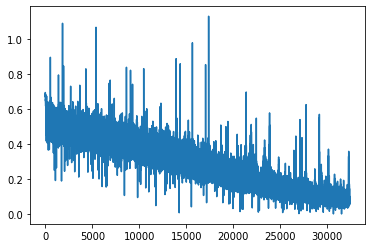

In [ ]:
# # model train fi
# max_acc_fi = 0
# loss_list = []
# for epoch in tqdm(range(epochs)):
#     model_fi.train()
#     batch_num = 0
#     for question_vec, document_vec, label in train_loader_fi:
#         predict_label = model_fi(question_vec, document_vec)
#         loss = criterion(predict_label, label)

#         pred = predict_label.max(-1, keepdim=True)[1]
#         acc = pred.eq(label.view_as(pred)).sum().item() / predict_label.shape[0]
#         optimizer_fi.zero_grad()
#         if (acc > max_acc_fi):
#             max_acc_fi = acc
#             torch.save(model_fi.state_dict(), 'model_fi.pth')
#         loss.backward()
#         optimizer_fi.step()
#         batch_num += 1
#         loss_list.append(round(loss.item(), 4))
#     if epoch % 5 == 0:
#         print("epoch:", epoch, "batch_num:", batch_num, "loss:", round(loss.item(), 4), "acc:", acc)
# print("max_acc_fi:", max_acc_fi)

# lr model
max_acc_fi = 0
loss_list = []
for epoch in tqdm(range(epochs)):
    lr_model_fi.train()
    batch_num = 0
    for question_vec, document_vec, label in train_loader_fi:
        data = torch.cat((question_vec, document_vec), 1)
        predict_label = lr_model_fi(data)
        loss = criterion(predict_label, label)

        pred = predict_label.max(-1, keepdim=True)[1]
        acc = pred.eq(label.view_as(pred)).sum().item() / predict_label.shape[0]
        optimizer_fi_lr.zero_grad()
        if (acc > max_acc_fi):
            max_acc_fi = acc
            torch.save(lr_model_fi.state_dict(), 'lr_model_fi.pth')
        loss.backward()
        optimizer_fi_lr.step()
        batch_num += 1
        loss_list.append(round(loss.item(), 4))
    if epoch % 5 == 0:
        print("epoch:", epoch, "batch_num:", batch_num, "loss:", round(loss.item(), 4), "acc:", acc)
print("max_acc_fi:", max_acc_fi)

plt.cla()
plt.plot(loss_list)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
# model_en.load_state_dict(torch.load("model_en.pth"))

# predict_label = model_en(english_question_validation_set, english_document_validation_set)
# pred = predict_label.max(-1, keepdim=True)[1]
# label = english_answer_validation_set
# test_acc = pred.eq(label.view_as(pred)).sum().item() / predict_label.shape[0]


lr_model_en.load_state_dict(torch.load("lr_model_en.pth"))

predict_label = lr_model_en(torch.cat((english_question_validation_set, english_document_validation_set), 1))
pred = predict_label.max(-1, keepdim=True)[1]
label = english_answer_validation_set
test_acc = pred.eq(label.view_as(pred)).sum().item() / predict_label.shape[0]

report = classification_report(label.cpu(), pred.cpu(), output_dict=True)
print(pandas.DataFrame(report).transpose())

print("\ntest acc en:", test_acc)

              precision    recall  f1-score     support
0              0.559097  0.850505  0.674679  495.000000
1              0.687764  0.329293  0.445355  495.000000
accuracy       0.589899  0.589899  0.589899    0.589899
macro avg      0.623430  0.589899  0.560017  990.000000
weighted avg   0.623430  0.589899  0.560017  990.000000

test acc en: 0.5898989898989899


In [ ]:
# model_ja.load_state_dict(torch.load("model_ja.pth"))

# predict_label = model_ja(japanese_question_validation_set, japanese_document_validation_set)
# pred = predict_label.max(-1, keepdim=True)[1]
# label = japanese_answer_validation_set
# test_acc = pred.eq(label.view_as(pred)).sum().item() / predict_label.shape[0]


lr_model_ja.load_state_dict(torch.load("lr_model_ja.pth"))

predict_label = lr_model_ja(torch.cat((japanese_question_validation_set, japanese_document_validation_set), 1))
pred = predict_label.max(-1, keepdim=True)[1]
label = japanese_answer_validation_set
test_acc = pred.eq(label.view_as(pred)).sum().item() / predict_label.shape[0]

report = classification_report(label.cpu(), pred.cpu(), output_dict=True)
print(pandas.DataFrame(report).transpose())

print("\ntest acc ja:", test_acc)

              precision    recall  f1-score      support
0              0.527027  0.978764  0.685135   518.000000
1              0.851351  0.121622  0.212838   518.000000
accuracy       0.550193  0.550193  0.550193     0.550193
macro avg      0.689189  0.550193  0.448986  1036.000000
weighted avg   0.689189  0.550193  0.448986  1036.000000

test acc ja: 0.5501930501930502


In [ ]:
# model_fi.load_state_dict(torch.load("model_fi.pth"))

# predict_label = model_fi(finnish_question_validation_set, finnish_document_validation_set)
# pred = predict_label.max(-1, keepdim=True)[1]
# label = finnish_answer_validation_set
# test_acc = pred.eq(label.view_as(pred)).sum().item() / predict_label.shape[0]


lr_model_fi.load_state_dict(torch.load("lr_model_fi.pth"))

predict_label = lr_model_fi(torch.cat((finnish_question_validation_set, finnish_document_validation_set), 1))
pred = predict_label.max(-1, keepdim=True)[1]
label = finnish_answer_validation_set
test_acc = pred.eq(label.view_as(pred)).sum().item() / predict_label.shape[0]

report = classification_report(label.cpu(), pred.cpu(), output_dict=True)
print(pandas.DataFrame(report).transpose())

print("\ntest acc fi:", test_acc)

              precision    recall  f1-score      support
0              0.747287  0.571767  0.647849   843.000000
1              0.653218  0.806643  0.721868   843.000000
accuracy       0.689205  0.689205  0.689205     0.689205
macro avg      0.700252  0.689205  0.684859  1686.000000
weighted avg   0.700252  0.689205  0.684859  1686.000000

test acc fi: 0.6892052194543298


In [ ]:
lr_model_multi.load_state_dict(torch.load("lr_model_multi.pth"))

predict_label = lr_model_multi(torch.cat((english_question_validation_set, english_document_validation_set), 1))
pred = predict_label.max(-1, keepdim=True)[1]
label = english_answer_validation_set
test_acc = pred.eq(label.view_as(pred)).sum().item() / predict_label.shape[0]

report = classification_report(label.cpu(), pred.cpu(), output_dict=True)
print(pandas.DataFrame(report).transpose())

print("\ntest acc en:", test_acc)

NameError: ignored

In [ ]:
lr_model_multi.load_state_dict(torch.load("lr_model_multi.pth"))

predict_label = lr_model_multi(torch.cat((japanese_question_validation_set, japanese_document_validation_set), 1))
pred = predict_label.max(-1, keepdim=True)[1]
label = japanese_answer_validation_set
test_acc = pred.eq(label.view_as(pred)).sum().item() / predict_label.shape[0]

report = classification_report(label.cpu(), pred.cpu(), output_dict=True)
print(pandas.DataFrame(report).transpose())

print("\ntest acc ja:", test_acc)

In [ ]:
lr_model_multi.load_state_dict(torch.load("lr_model_multi.pth"))

predict_label = lr_model_multi(torch.cat((finnish_question_validation_set, finnish_document_validation_set), 1))
pred = predict_label.max(-1, keepdim=True)[1]
label = finnish_answer_validation_set
test_acc = pred.eq(label.view_as(pred)).sum().item() / predict_label.shape[0]

report = classification_report(label.cpu(), pred.cpu(), output_dict=True)
print(pandas.DataFrame(report).transpose())

print("\ntest acc fi:", test_acc)